<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-xsmall.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="left" src="images/VU-ETCBC-xsmall.png"/></a>
<a href="http://tla.mpi.nl" target="_blank"><img align="right" src="images/TLA-xsmall.png"/></a>
<a href="http://www.dans.knaw.nl" target="_blank"><img align="right"src="images/DANS-xsmall.png"/></a>

# About this notebook

This notebook illustrates the working of LAF-Fabric, a tool to analyze the data inside *LAF* resources (Linguistic Annotation Framework). We use it for a particular LAF resource: the Hebrew Bible with linguistic annotations. The software to get the Hebrew Bible in LAF is part of LAF-Fabric (see *emdros2laf*).

> **NB 1.** This is a static copy of the Gender notebook. You can download it, and if you have iPython installed and the LAF-Fabric, then you can run this notebook. And you can create many more notebooks like this, looking for patterns in the Hebrew Bible.

> **NB 2.** All software involved is open source, and the data is Open Access (not for commercial use). Click the logo:
<a href="http://www.persistent-identifier.nl/?identifier=urn%3Anbn%3Anl%3Aui%3A13-048i-71" target="_blank"><img align="right"src="images/etcbc4easy-small.png"/></a>

# Gender in the Hebrew Bible

Words in Hebrew are either masculine, or feminine, or unknown.

We want to plot the percentage of masculine and feminine words per chapter.

## The LAF way
In the Hebrew LAF data, some nodes are annotated as ``word``, and some nodes as ``chapter``
(there are many more kinds of node, of course).

The names of chapters and the genders of words are coded as features inside annotations to these
nodes.

## More on feature names
The features we need are present in an annotation space named ``etcbc4`` (after the name and version of this LAF resource).
The chapter features are labeled with ``sft`` and the other features with ``ft``.

When LAF-Fabric compiles features into binary data, it forgets the annotations in which the features come,
but the annotation *space* and *label* are retained in a double prefix to the feature name.

LAF-Fabric remembers those features by their *fully qualified* names: ``etcbc4:ft.gender``, ``etcbc4:sft.chapter`` etc.
There may also be annotations without feature contents.

# Importing

The next cell loads the required libraries and creates a task processor.

In [1]:
import sys
import collections

from laf.fabric import LafFabric
fabric = LafFabric(verbose='DETAIL')

  0.00s This is LAF-Fabric 4.8.1
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: https://shebanq.ancient-data.org/static/docs/featuredoc/texts/welcome.html

  0.00s DETAIL: Data dir = /Users/dirk/laf/laf-fabric-data
  0.00s DETAIL: Laf dir = /Users/dirk/laf/laf-fabric-data
  0.00s DETAIL: Output dir = /Users/dirk/laf/laf-fabric-output


# Loading

The processor needs data. Here is where we say what data to load. We do not need the XML identifiers as they show up in the original LAF resource. But we do need a few features of nodes, namely the ones that give us the gender of the words, and the numbers of the chapters and the books in which the chapters are contained.

The *init* function actually draws that data in, and it will take a few seconds. 

It needs to know the name of the **source**. 
This name corresponds with a subdirectory in your *work_dir*.

The '--' means that we do not draw in an **annox** (extra annotation package). 
If you want to do that, this is the place to give the name of such a package, which must be a subdirectory name inside the *annotations* directory in your *work_dir*.

Then **gender** is just a name we choose to give to this task.
This name determines where on the filesystem the log file and output (if any) will be put:
a subdirectory *gender* inside the **source** directory inside your *output_dir*.

The last argument to ``load()`` is a dictionary of data items to load.

The **primary** key indicates whether the primary data itself must be loaded.
Tasks can then use methods to find the primary data that is attached to a node.
For the Hebrew data this is hardly necessary, because the words have textual information as features on them.

The **xmlids** are tables mapping nodes and edges to the original xml identifiers they have in the original LAF source.
Most tasks do not need this.
Only when a task needs to link new annotations to nodes and edges and write the result as an additional LAF file,
it needs to know the original identifiers.

The **features** to be loaded are specified by two strings, one for node features and one for edge features.
For all these features, data will be loaded, and all other features' data will be unloaded, if still loaded.

**Caution: Missing feature data**

If you forget to mention a feature in the load declaration and you
do use it in your task,
LAF-Fabric will stop your task and shout error messages at you.
If you declare features that do not exist in the LAF data, you just get
a warning. But if you try to use such features, you get also a loud error.

In [2]:
fabric.load('etcbc4b', '--', 'gender',
{
    "primary": False,
    "xmlids": {"node": False, "edge": False},
    "features": ("otype gn chapter book", ""),
})
exec(fabric.localnames.format(var='fabric'))

  0.00s LOADING API: please wait ... 
  0.00s USING main: etcbc4b DATA COMPILED AT: 2015-11-02T15-08-56
  2.01s LOGFILE=/Users/dirk/laf/laf-fabric-output/etcbc4b/gender/__log__gender.txt
  2.01s INFO: DATA LOADED FROM SOURCE etcbc4b AND ANNOX  FOR TASK gender AT 2016-09-09T14-48-44


# API

In order to write an efficient task,
it is convenient to import the names of the API methods as *local variables*.
The lookup of names in Python is fastest for local names.
And it makes the code much cleaner. The method ``load()`` does this.
See the [API reference](http://laf-fabric.readthedocs.org/texts/API-reference.html) for full documentation.

## F
All that you want to know about features and are not afraid to ask.
It is an object, and for each feature that you have declared, it has a member
with a handy name. For example,

    F.etcbc4_db_otype

is a feature object
that corresponds with the LAF feature given in an annotation 
in the annotation space ``etcbc4``, with label ``db`` and name ``otype``.
It is a node feature, because otherwise we had to use ``FE`` instead of ``F``.

You do not have to mention the annotation space and label, Laf-Fabric will find out what they should be
given the available features. If there is confusion, Laf-Fabric will tell you, and you can supply
more full names.

You can look up a feature value of this feature, say for node ``n``, by saying

    F.otype.v(n) 

## NN(test=function value=something values=list of somethings)
If you want to walk through all the nodes, possibly skipping some, then this is your method.
It is an *iterator* that yields a new node everytime it is called.
The order is so-called *primary data order*, which will be explained below.
The ``test`` and ``value`` and ``values`` arguments are optional.
If given, ``test`` should be a *callable* with one argument, returning a string;
``value`` should be a string, ``values`` a list of strings.
``test`` will be called for each passing node,
and if the value returned is not equal to the given ``value`` and not a member of ``values``,
the node will be skipped.

### msg
Issues a timed message to the standard error and to the log file.

### infile(filename)
Creates a open file handle for reading a file in your task output directory 

### outfile(filename)
Creates a open file handle for writing a file in your task output directory

### my_file(filename)
Gives the full path to a file in your task output directory

### Available features

The *F_all* component delivers a list of available node features in the chosen source, 
and like wise *FE_all* yields the edge features.
Let us see what we have got. For convenience, the components *fF_all* and *fFE_all* produce formatted outputs for
these feature lists.

In [6]:
print(fF_all)
print(fFE_all)

etcbc4:
	db.maxmonad:
	db.minmonad:
	db.monads:
	db.oid:
	db.otype:
	ft.code:
	ft.det:
	ft.dist:
	ft.dist_unit:
	ft.domain:
	ft.function:
	ft.g_cons:
	ft.g_cons_utf8:
	ft.g_lex:
	ft.g_lex_utf8:
	ft.g_nme:
	ft.g_nme_utf8:
	ft.g_pfm:
	ft.g_pfm_utf8:
	ft.g_prs:
	ft.g_prs_utf8:
	ft.g_uvf:
	ft.g_uvf_utf8:
	ft.g_vbe:
	ft.g_vbe_utf8:
	ft.g_vbs:
	ft.g_vbs_utf8:
	ft.g_word:
	ft.g_word_utf8:
	ft.gn:
	ft.is_root:
	ft.kind:
	ft.language:
	ft.lex:
	ft.lex_utf8:
	ft.ls:
	ft.mother_object_type:
	ft.nme:
	ft.nu:
	ft.number:
	ft.pdp:
	ft.pfm:
	ft.prs:
	ft.ps:
	ft.rela:
	ft.sp:
	ft.st:
	ft.tab:
	ft.trailer_utf8:
	ft.txt:
	ft.typ:
	ft.uvf:
	ft.vbe:
	ft.vbs:
	ft.vs:
	ft.vt:
	sft.book:
	sft.chapter:
	sft.label:
	sft.verse:
etcbc4:
	ft.distributional_parent:
	ft.functional_parent:
	ft.mother:
laf:
	('', 'x'):
	('', 'y'):


# Task Execution

We need to get an output file to write to.
A simple method provides a handle to a file open for writing.
The file will be created in the *output_dir*, under the subdir *etcbc4*, under the subdir *gender*.

In [3]:
table = outfile('table.tsv')

All open files (reading and writing) will be closed with

    close()

below.

## Walking the nodes

Here we loop over a bunch of nodes (in fact over all nodes), in a convenient document order.

### Node order
There is an implicit partial order on nodes.
The short story is: the nodes that are linked to primary data, inherit the order that is present
in the primary data.
The long story is a bit more complicated, since nodes may be attached to multiple ranges of 
primary data.

See [node order](http://laf-fabric.readthedocs.org/texts/API-reference.html#node-order) for details.
If you don't, it might be enough to know
that *embedding* nodes always come before *embedded* nodes, meaning that if a node happens 
to be attached to a big piece of primary data, and a second node to a part of that data,
then the node with the bigger attachment comes first.

When there is no inclusion either way, and the start and end points are the same, the order is left undefined. 

### Initialization
We initialize the counters in which we store the word counts.
We keep track of the chapter we are in and accumulate counts of the words, masculine and feminine.
For each chapter we create entries in the *ch*, *m* and *f* lists.

Note also the progress messages after each chapter.

In [4]:
stats = [0, 0, 0]
cur_chapter = None
cur_book = None
ch = []
m = []
f = []

In [5]:
for node in NN():
    otype = F.otype.v(node)
    if otype == "word":
        stats[0] += 1
        if F.gn.v(node) == "m":
            stats[1] += 1
        elif F.gn.v(node) == "f":
            stats[2] += 1
    elif otype == "chapter":
        if cur_chapter != None:
            masc = 0 if not stats[0] else 100 * float(stats[1]) / stats[0]
            fem = 0 if not stats[0] else 100 * float(stats[2]) / stats[0]
            ch.append(cur_chapter)
            m.append(masc)
            f.append(fem)
            table.write("{},{},{}\n".format(cur_chapter, masc, fem))
        else:
            table.write("{},{},{}\n".format('book chapter', 'masculine', 'feminine'))
        this_book = F.book.v(node)
        this_chapnum = F.chapter.v(node)
        this_chapter = "{} {}".format(this_book, this_chapnum)
        if this_book != cur_book:
            sys.stderr.write("\n{}".format(this_book))
            cur_book = this_book
        sys.stderr.write(" {}".format(this_chapnum))
        stats = [0, 0, 0]
        cur_chapter = this_chapter


Genesis 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
Exodus 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
Leviticus 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
Numeri 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
Deuteronomium 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
Josua 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Judices 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Samuel_I 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
Samuel_II 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Reges_I 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22
Reges_II 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25


# Closing

We need to close open files. This is exactly what the next statement does.

In [7]:
close()

    22s Results directory:
/Users/dirk/SURFdrive/laf-fabric-output/etcbc4b/gender

__log__gender.txt                       217 Fri Nov 13 14:09:01 2015
table.tsv                             43234 Fri Nov 13 14:09:01 2015


# Showing off

Everything is still in memory. Now it is the time to generate a graphical representation of the data.

The *matplotlib* package is full of instruments to do that.

But let us first have a look at a few rows of the data itself.

In [8]:
import pandas
import matplotlib.pyplot as plt
from IPython.display import display
pandas.set_option('display.notebook_repr_html', True)
%matplotlib inline

The files that have been generated reside in a subdirectory of your work directory.
You can easily refer to them as follows:

In [9]:
table_file = my_file('table.tsv')
df = pandas.read_csv(table_file)

In [10]:
df.head(100)

,book chapter,masculine,feminine
0,Genesis 1,42.347697,5.794948
1,Genesis 2,38.663968,7.692308
2,Genesis 3,37.474950,10.020040
3,Genesis 4,43.046358,11.920530
4,Genesis 5,40.748441,18.918919
5,Genesis 6,36.613272,9.610984
6,Genesis 7,33.596838,11.462451
7,Genesis 8,31.300813,9.959350
8,Genesis 9,37.972167,9.741551
9,Genesis 10,30.679157,4.683841


Now let's get *matplotlib* to work.
Here we just show a line graph of 20 chapters.
If you want to see another series of chapters,
just modify the *start* and *end* variables below and execute again by pressing *Shift Enter*.
You can repeat this as often as you like without re-running earlier steps.

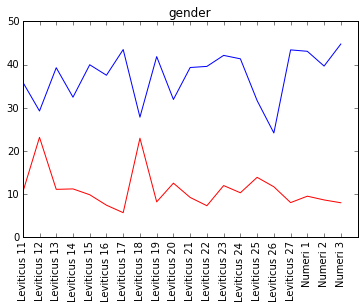

In [11]:
x = range(len(ch))
start = 100
end = 120
fig = plt.figure()
plt.plot(x[start:end], m[start:end], 'b-', x[start:end], f[start:end], 'r-')
plt.axis([start, end, 0, 50])
plt.xticks(x[start:end], ch[start:end], rotation='vertical')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15);
plt.title('gender');

## Note the chapters where the feminine words peak: Leviticus 12 and 18.

Finally, save the chart.

In [12]:
fig.savefig('gender.png')

![saved chart](gender.png)